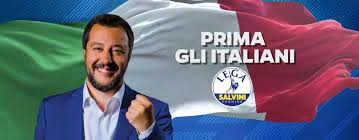

# Install packages and lib

In [ ]:
!pip install -U pdpipe
!pip install -U pandasql -q
!pip install -U plotly-express
!pip install twint
!pip install pysqldf
!pip uninstall twint -y
!git clone --depth=1 https://github.com/twintproject/twint.git
%cd twint/
!pip3 install . -r requirements.txt
%cd ..

In [5]:
#import twint
import os
import warnings
import re
import pdpipe as pdp
import nest_asyncio
import pandas as pd
from pysqldf import SQLDF
import datetime as dt
from pandasql import sqldf
nest_asyncio.apply()
warnings.filterwarnings("ignore")

In [3]:
# getting automatic reloading and inline plotting for the entire notebook
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%reload_ext google.colab.data_table
%config InlineBackend.figure_format = 'retina'

In [8]:
# declaring constants to use during the process
BASEPATH = '/content'
DATASET = 'tweet_salvini.csv'
PATH = os.path.join(BASEPATH,DATASET)

Functions

# Data ingestion

In [ ]:
# Configure
c = twint.Config()
c.Username = 'matteosalvinimi'
c.Store_object=True
c.Pandas=True
# Run
twint.run.Search(c)

In [9]:
df = pd.read_csv(PATH,",",index_col=0)
df.head()

,id,conversation_id,created_at,date,timezone,place,tweet,language,hashtags,cashtags,user_id,user_id_str,username,name,day,hour,link,urls,photos,video,thumbnail,retweet,nlikes,nreplies,nretweets,quote_url,search,near,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest
0,152685915721043968,152685915721043968,1.325238e+12,2011-12-30 09:42:13,0,NaN,"Vietare i botti di fine anno, se Pisapia ci ri...",it,[],[],270839361,270839361,matteosalvinimi,Matteo Salvini,5,9,https://twitter.com/matteosalvinimi/status/152...,['http://www.matteosalvini.eu/da-palazzo-marin...,[],0,NaN,False,0,1,3,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
1,152386287326867456,152386287326867456,1.325167e+12,2011-12-29 13:51:36,0,NaN,Canone Rai: che ingenui a non abolirlo. http:...,it,[],[],270839361,270839361,matteosalvinimi,Matteo Salvini,4,13,https://twitter.com/matteosalvinimi/status/152...,['http://www.matteosalvini.eu/rassegna-stampa/...,[],0,NaN,False,0,1,1,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
2,152379906075009024,152379906075009024,1.325165e+12,2011-12-29 13:26:15,0,NaN,"Monti é elegante ed educato, dicono. Ma se a f...",it,[],[],270839361,270839361,matteosalvinimi,Matteo Salvini,4,13,https://twitter.com/matteosalvinimi/status/152...,[],[],0,NaN,False,0,5,5,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
3,149877613119275009,149877613119275009,1.324569e+12,2011-12-22 15:43:02,0,NaN,"Se volete rivedere la puntata de ""L'Arena"" del...",it,[],[],270839361,270839361,matteosalvinimi,Matteo Salvini,4,15,https://twitter.com/matteosalvinimi/status/149...,['http://www.rai.tv/dl/RaiTV/programmi/media/C...,[],0,NaN,False,0,0,0,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
4,149486758717964288,149486758717964288,1.324475e+12,2011-12-21 13:49:55,0,NaN,"Montezemolo in politica, tifosi della Ferrari ...",it,[],[],270839361,270839361,matteosalvinimi,Matteo Salvini,3,13,https://twitter.com/matteosalvinimi/status/149...,[],[],0,NaN,False,0,3,2,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN


In [10]:
pipeline = pdp.PdPipeline(
                          [pdp.ColRename({'nlikes':'likes','nreplies':'replies','nretweets':'retweets','date':'timestamp'}),
                           pdp.ColDrop(['id','conversation_id','created_at','timezone','place','language','username','cashtags','user_id','user_id_str','name','day','hour','urls','photos','video',
                                        'thumbnail','retweet','quote_url','search','near','geo','source','user_rt_id','user_rt','retweet_id','reply_to','retweet_date','translate','trans_src','trans_dest']),
                           pdp.DropDuplicates(columns=None)
                           ]
)
df_proc = pipeline.apply(df,verbose = True)
df_proc['timestamp'] = pd.to_datetime(df['date'])
df_proc['date']= pd.to_datetime(df_proc['timestamp']).dt.date
df_proc.head()

- Rename columns with {'nlikes': 'likes', 'nreplies': 'replies',
  'nretweets': 'retweets', 'date': 'timestamp'}
- Drop columns id, conversation_id, created_at, timezone, place,
  language, username, cashtags, user_id, user_id_str, name, day, hour,
  urls, photos, video, thumbnail, retweet, quote_url, search, near, geo,
  source, user_rt_id, user_rt, retweet_id, reply_to, retweet_date,
  translate, trans_src, trans_dest
- Drop duplicates in columns
0 rows dropped.


,timestamp,tweet,hashtags,link,likes,replies,retweets,date
0,2011-12-30 09:42:13,"Vietare i botti di fine anno, se Pisapia ci ri...",[],https://twitter.com/matteosalvinimi/status/152...,0,1,3,2011-12-30
1,2011-12-29 13:51:36,Canone Rai: che ingenui a non abolirlo. http:...,[],https://twitter.com/matteosalvinimi/status/152...,0,1,1,2011-12-29
2,2011-12-29 13:26:15,"Monti é elegante ed educato, dicono. Ma se a f...",[],https://twitter.com/matteosalvinimi/status/152...,0,5,5,2011-12-29
3,2011-12-22 15:43:02,"Se volete rivedere la puntata de ""L'Arena"" del...",[],https://twitter.com/matteosalvinimi/status/149...,0,0,0,2011-12-22
4,2011-12-21 13:49:55,"Montezemolo in politica, tifosi della Ferrari ...",[],https://twitter.com/matteosalvinimi/status/149...,0,3,2,2011-12-21


In [ ]:
display(df_proc)

Shape of the dataset

In [11]:
print("Shape's dataset:", df_proc.shape)
print("Records of the dataset:", df_proc.shape[0])
print("Columns of the dataset:", df_proc.shape[1])

Shape's dataset: (47519, 8)
Records of the dataset: 47519
Columns of the dataset: 8


Check missing values

In [ ]:
df_proc.isnull().sum()

date        0
tweet       0
hashtags    0
link        0
likes       0
replies     0
retweets    0
dtype: int64

Info related to the datatype of the columns of the dataset

In [12]:
#Data Types
df_proc.dtypes

timestamp    datetime64[ns]
tweet                object
hashtags             object
link                 object
likes                 int64
replies               int64
retweets              int64
date                 object
dtype: object

# Tweet and profile analysis

## Hashtag used

In [ ]:
hashtag_list = []
for index,tr in df_proc.iterrows():
  for x in tr['hashtags']:
    print(x)
    hashtag_list.append(x)

In [57]:
my_x = ['berlusconi', 'primailnord']
for x in (my_x):
  print(x)

berlusconi
primailnord


## Engagement overview

In [13]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [15]:
selected_columns = df_proc[["date","replies","likes","retweets"]]
df_analytic = selected_columns.copy()
df_analytic.head()

,date,replies,likes,retweets
0,2011-12-30,1,0,3
1,2011-12-29,1,0,1
2,2011-12-29,5,0,5
3,2011-12-22,0,0,0
4,2011-12-21,3,0,2


In [16]:
pysqldf = lambda q: sqldf(q, globals())
q = """
    SELECT date,
           count(1) as num_tweets,
           sum(replies) as num_replies,
           sum(likes) as num_likes,
           sum(retweets) as num_retweets
    FROM df_analytic A
    GROUP BY date;
    """
df_grouped_numeric = pysqldf(q)
df_grouped_numeric.head()

,date,num_tweets,num_replies,num_likes,num_retweets
0,2011-03-23,1,14,5,9
1,2011-03-24,1,0,2,4
2,2011-04-07,1,0,0,0
3,2011-04-08,1,0,0,0
4,2011-04-11,1,0,0,0


In [35]:
engage_plot = make_subplots(rows=2, cols=2)

engage_plot.add_trace(
    go.Scatter(x=df_grouped_numeric['date'], y=df_grouped_numeric['num_tweets'], mode='lines', line_color='#f0f921',name = 'Number of tweets'),
    row=1, col=1
)

engage_plot.add_trace(
    go.Scatter(x=df_grouped_numeric["date"], y=df_grouped_numeric["num_replies"],mode='lines', line_color='#ed7953',name = 'Number of replies'),
    row=1, col=2
)

engage_plot.add_trace(
    go.Scatter(x=df_grouped_numeric["date"], y=df_grouped_numeric["num_likes"],mode='lines', line_color='#7201a8',name='Number of likes',tit),
    row=2, col=1
)
engage_plot.add_trace(
    go.Scatter(x=df_grouped_numeric["date"], y=df_grouped_numeric["num_retweets"],mode='lines', line_color='#0d0887',name='Number of retweets'),
    row=2, col=2
)

engage_plot.update_layout(title_text="Engagement and Twitter usage")
engage_plot.show()

## Top 5 retweeted,liked,replied tweets

In [38]:
df_most_retweeted = df_proc.sort_values(by=['retweets'],ascending=False).head()
df_most_retweeted.drop(columns=['date','hashtags','link','likes','replies'],inplace=True)
df_most_retweeted

,timestamp,tweet,retweets
22268,2018-10-28 22:22:23,🔴Anche in #Brasile i cittadini hanno mandato a...,5139
23176,2018-08-25 21:12:10,Grazie a chi sta twittando #nessunotocchiSalvi...,4339
46016,2020-01-01 16:01:04,Strattonato da fan agitata ❤️ https://t.co/ZP...,4320
31949,2019-05-26 21:24:08,Una sola parola: GRAZIE Italia! 🇮🇹 https://t....,4248
22404,2018-10-19 16:52:52,++ 🔴Video incredibile! Condividi il più possib...,3741


In [40]:
df_most_replied = df_proc.sort_values(by=['replies'],ascending=False).head()
df_most_replied.drop(columns=['date','hashtags','link','likes','replies'],inplace=True)
df_most_replied

,timestamp,tweet,retweets
42955,2020-04-10 18:17:34,🔴USARE la tivù di Stato per dire falsità e far...,1374
34839,2019-02-10 00:37:16,#Mahmood............... mah............ La can...,1137
43769,2020-03-16 10:14:24,"#Salvini: Sì, confesso. Ieri sono andato a pie...",659
30231,2019-08-09 09:41:32,Chi perde tempo vuole solo salvare la poltrona...,1786
31004,2019-07-02 18:45:22,🔴 Per la magistratura italiana ignorare le leg...,1535


In [39]:
df_most_liked = df_proc.sort_values(by=['likes'],ascending=False).head()
df_most_liked.drop(columns=['date','hashtags','link','likes','replies'],inplace=True)
df_most_liked

,timestamp,tweet,retweets
22268,2018-10-28 22:22:23,🔴Anche in #Brasile i cittadini hanno mandato a...,5139
39959,2020-07-07 19:04:07,#Forçabolsonaro!,3016
46016,2020-01-01 16:01:04,Strattonato da fan agitata ❤️ https://t.co/ZP...,4320
31949,2019-05-26 21:24:08,Una sola parola: GRAZIE Italia! 🇮🇹 https://t....,4248
23176,2018-08-25 21:12:10,Grazie a chi sta twittando #nessunotocchiSalvi...,4339


## Timing of tweet

In [67]:
df_grouped_numeric['date']= pd.to_datetime(df_grouped_numeric['date'])
df_grouped_numeric['year_tweet'] = df_grouped_numeric['date'].dt.year
df_grouped_numeric['month_tweet'] = df_grouped_numeric['date'].dt.month
df_grouped_numeric['day_tweet'] = df_grouped_numeric['date'].dt.day
df_grouped_numeric['weekday_tweet'] = df_grouped_numeric['date'].dt.day_name()
df_grouped_numeric['month_name_tweet'] = df_grouped_numeric['date'].dt.strftime('%b')
df_grouped_numeric.head()

,date,num_tweets,num_replies,num_likes,num_retweets,year_tweet,month_tweet,day_tweet,weekday_tweet,month_name_tweet
0,2011-03-23,1,14,5,9,2011,3,23,Wednesday,Mar
1,2011-03-24,1,0,2,4,2011,3,24,Thursday,Mar
2,2011-04-07,1,0,0,0,2011,4,7,Thursday,Apr
3,2011-04-08,1,0,0,0,2011,4,8,Friday,Apr
4,2011-04-11,1,0,0,0,2011,4,11,Monday,Apr


In [82]:
df_m = df_grouped_numeric.pivot_table(index="month_name_tweet", columns="weekday_tweet", values="num_tweets",aggfunc= 'sum')
df_m = df_m[['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']]
df_m

weekday_tweet,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
month_name_tweet,,,,,,,
Apr,565,629,576,696,481,323,404
Aug,393,379,374,408,406,352,281
Dec,550,607,406,472,386,401,579
Feb,686,635,626,624,491,577,502
Jan,604,809,642,837,513,384,558
Jul,450,506,469,522,471,344,451
Jun,589,657,597,618,603,373,455
Mar,540,701,574,782,484,493,454
May,778,851,673,832,760,499,741


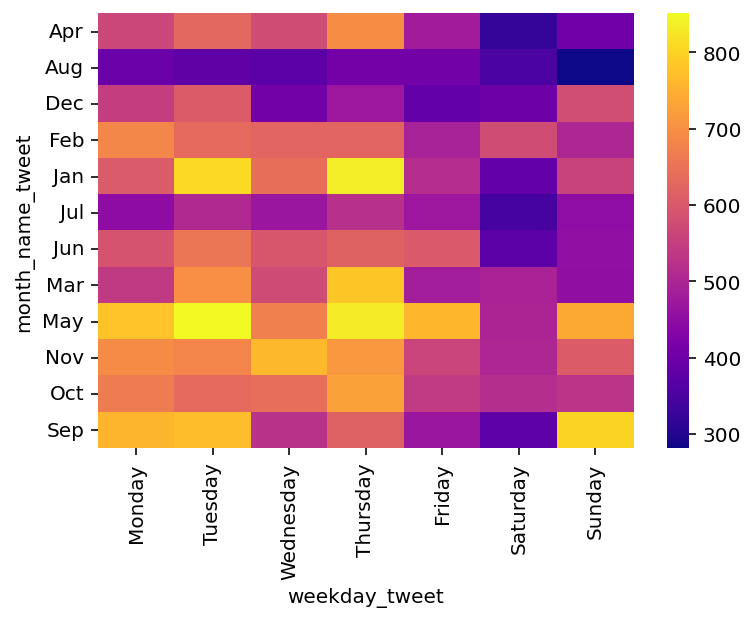

In [99]:
import seaborn as sns
heat_map = sns.heatmap(df_m,cmap="plasma")

# Reporting

In [ ]:
!pip3 install --upgrade datapane -q

In [32]:
import datapane as dp

In [34]:
#login
dp.login(token='f4d00658acddf65a17bd21cbb1e8c34492f298ff', server='https://datapane.com/')

Connected successfully to https://datapane.com as airaghidavide


'airaghidavide'

In [103]:
#build the report
r = dp.Report(
  dp.Text('Twitter profile report - Matteo Salvini'), #add description to the report
  dp.Select(blocks=[
        dp.DataTable(df_proc, label='Full dataset'),
        dp.DataTable(df_most_retweeted, label='Top 5 retweeted tweets'),
        dp.DataTable(df_most_replied, label='Top 5 replied tweets'),
        dp.DataTable(df_most_liked, label='Top 5 liked tweets'),
    ]),
  dp.Plot(engage_plot,responsive= True),
  dp.Plot(heat_map) 
)

In [104]:
#publish or upload & open report in the browser
r.upload(name = 'Twitter profile report - Matteo Salvini',open=True,visibility = dp.Visibility.PORTFOLIO)

Uploading report and associated data - *please wait...*
Report successfully uploaded at https://datapane.com/u/airaghidavide/reports/M7bQbw3/twitter-profile-report-matteo-salvini/, follow the link to view and share your report.
